# Objectives:
Explore the following questions:
- Does k-means provide a good threshold for number of unique annotators per cluster?
- If we only pay attention to clusters with many unique annotators (to the right of the k-means line in the figure above), how do the sensitivity and error rate change with increased spot density?

# Takeaways:
- For this set of images, k-means does seem to provide a good threshold for number of unique annotators per cluster. 

In the histograms below, the right side of the k-means line tends to be completely or almost completely comprised of clusters near some reference annotation. (Large chunks of green to the left of the kmeans line, as in the first histogram below, typically represent instances where the clustering algorithm (AffinityPropagation) returned a lot of centroids on top of each other in one location (so they're colored green because they're near some spot). It's on my to-do list to investigate this, but for now it looks like these artifacts are being screened out anyway.)

- TPR (number of correct clusters found / number of spots) trends downward as spot density increases. FPR (number of incorrect clusters found / total number of clusters) varies erratically with spot density.

It will be interesting to see how declumping affects these behaviors.

# Next steps:
### Declumping
- Investigate the distribution of how many non-duplicate-workers are in each cluster
    - Automatically find clumpiness threshold (to keep clusters in which > threshold of unique workers in the cluster have clicked in that cluster multiple times).
    - Do any of these clumpy clusters show obvious degrees of clumpiness (lots of workers annotate 2x, 3x, etc)? If so, we’d have the k needed to apply partitioning, e.g. k-means, to that clump.
- Flag areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness


In [14]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

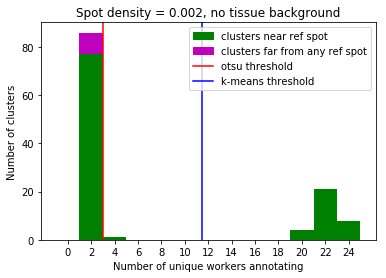

Using only clusters to the right of the k-means threshold:
TPR = 0.79
FPR = 0.06


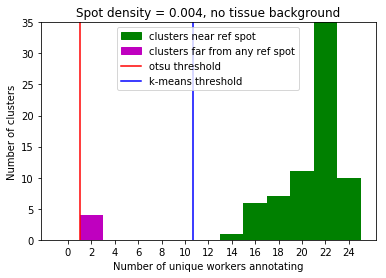

Using only clusters to the right of the k-means threshold:
TPR = 0.85
FPR = 0.06


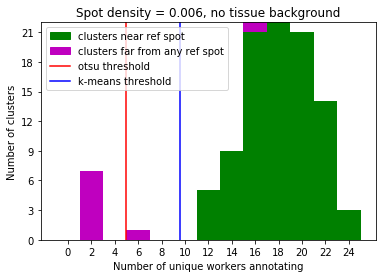

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.06


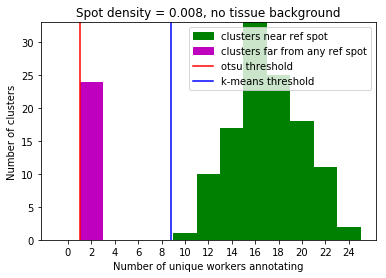

Using only clusters to the right of the k-means threshold:
TPR = 0.62
FPR = 0.18


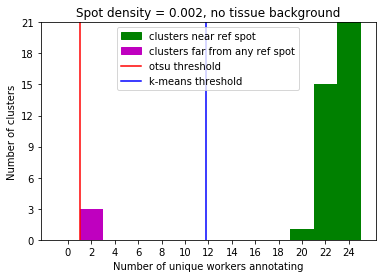

Using only clusters to the right of the k-means threshold:
TPR = 0.87
FPR = 0.08


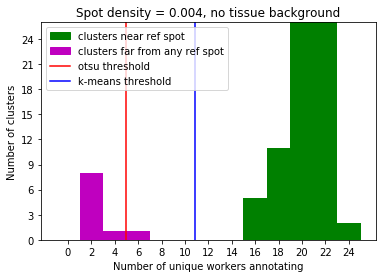

Using only clusters to the right of the k-means threshold:
TPR = 0.86
FPR = 0.04


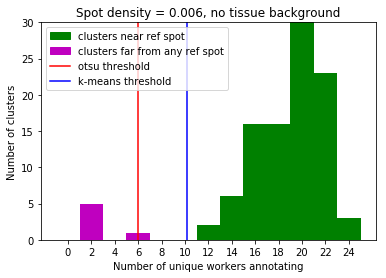

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.06


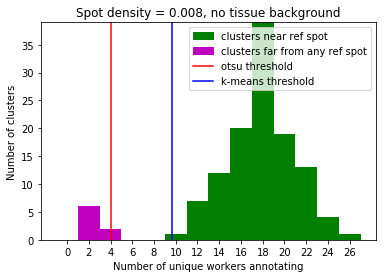

Using only clusters to the right of the k-means threshold:
TPR = 0.7
FPR = 0.06


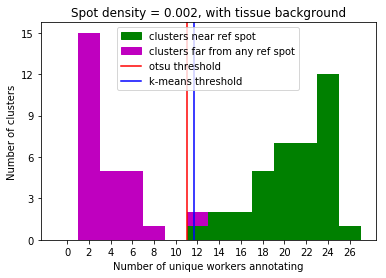

Using only clusters to the right of the k-means threshold:
TPR = 0.67
FPR = 0.3


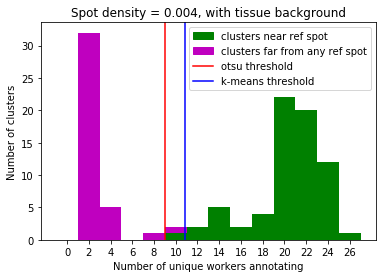

Using only clusters to the right of the k-means threshold:
TPR = 0.77
FPR = 0.12


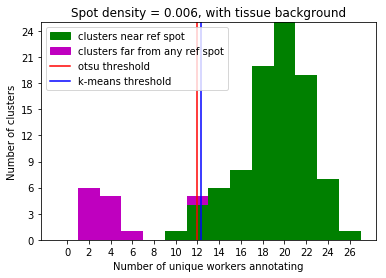

Using only clusters to the right of the k-means threshold:
TPR = 0.63
FPR = 0.14


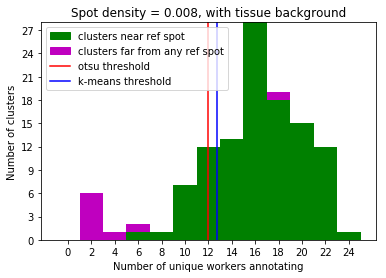

Using only clusters to the right of the k-means threshold:
TPR = 0.53
FPR = 0.06


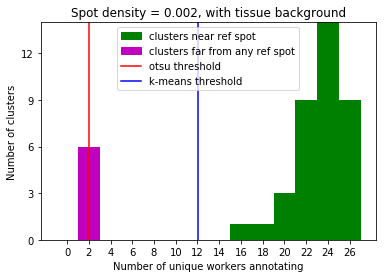

Using only clusters to the right of the k-means threshold:
TPR = 0.87
FPR = 0.08


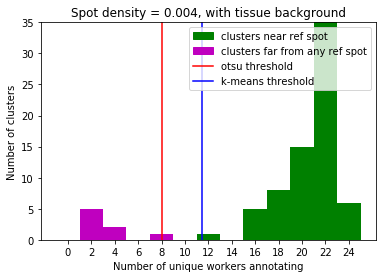

Using only clusters to the right of the k-means threshold:
TPR = 0.81
FPR = 0.1


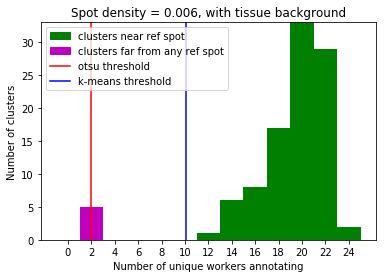

Using only clusters to the right of the k-means threshold:
TPR = 0.78
FPR = 0.05


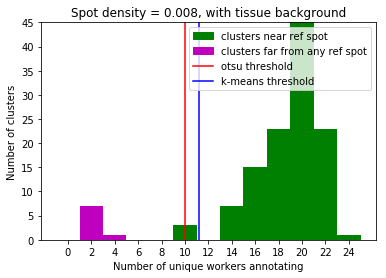

Using only clusters to the right of the k-means threshold:
TPR = 0.69
FPR = 0.06


In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)

            # Find separation between clusters with few and many unique annotators. 
            plot_title = "Spot density = " + str(density) + ", "
            if (json_filename == 'Spots_density_no_tissue.json'):
                plot_title += 'no tissue background'
            else:
                plot_title += 'with tissue background'
            bigger_window_size = False
            sa.plot_annotations_per_cluster(anno_one_image, clustering_params, show_correctness, correctness_threshold, csv_filepath, img_filename, plot_title, bigger_window_size)

            clusters = sa.get_clusters(anno_one_image, clustering_params)
            total_num_clusters = len(clusters.index)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)

            # Calculate and store detection rate (sensitivity: num_detected_actual_spots/num_actual_spots)
            # and false positive rate (error rate: num_detected_not_spots/all_detected_spots)
            num_detected_actual_spots = 0
            num_detected_not_spots = 0
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            for i in range(len(large_clusters.index)):
                row = clusters.iloc[[i]]
                centroid_x = row.iloc[0]['centroid_x']
                centroid_y = row.iloc[0]['centroid_y']
                centroid_coord = [[centroid_x, centroid_y]]
                dist, ind = ref_kdt.query(centroid_coord, k=1)
                distance = dist[0][0]
                if (distance <= correctness_threshold):
                    num_detected_actual_spots += 1
                else:
                    num_detected_not_spots += 1
            num_actual_spots = len(pd.read_csv(csv_filepath).index)
            TPR = num_detected_actual_spots/num_actual_spots
            FPR = num_detected_not_spots/(num_detected_not_spots+num_detected_actual_spots)
            if (json_filename == 'Spots_density_no_tissue.json'):
                TPR_list_no_tissue.append(TPR)
                FPR_list_no_tissue.append(FPR)
            else:
                TPR_list_with_tissue.append(TPR)
                FPR_list_with_tissue.append(FPR)
            print("Using only clusters to the right of the k-means threshold:")
            print("TPR = " + str(round(TPR,2)))
            print("FPR = " + str(round(FPR,2)))

### If we only pay attention to clusters with many unique annotators (to the right of the k-means line in the figure above), how do the sensitivity and error rate change with increased spot density?
I separated out FPR vs. Density and TPR vs. Density because it was hard to get an understanding of the behavior just looking at TPR vs. FPR.

In [18]:
# separate SNR 5 and 10
FPR_w_tissue_snr_5 = FPR_list_with_tissue[0:4]
TPR_w_tissue_snr_5 = TPR_list_with_tissue[0:4]
FPR_no_tissue_snr_5 = FPR_list_no_tissue[0:4]
TPR_no_tissue_snr_5 = TPR_list_no_tissue[0:4]

FPR_w_tissue_snr_10 = FPR_list_with_tissue[4:8]
TPR_w_tissue_snr_10 = TPR_list_with_tissue[4:8]
FPR_no_tissue_snr_10 = FPR_list_no_tissue[4:8]
TPR_no_tissue_snr_10 = TPR_list_no_tissue[4:8]

leg_elem_1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#ffcc99', label='w/ tissue, SNR = 5')
leg_elem_2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='orange', label='w/ tissue, SNR = 10')
leg_elem_3 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#33ccff', label='no tissue, SNR = 5')
leg_elem_4 = Line2D([0],[0], marker='o', color='w', markerfacecolor='blue', label='no tissue, SNR = 10')

legend_elements = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4]

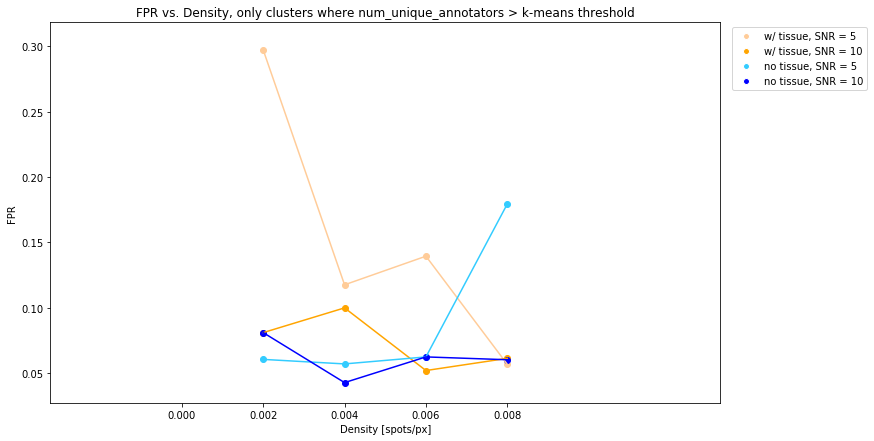

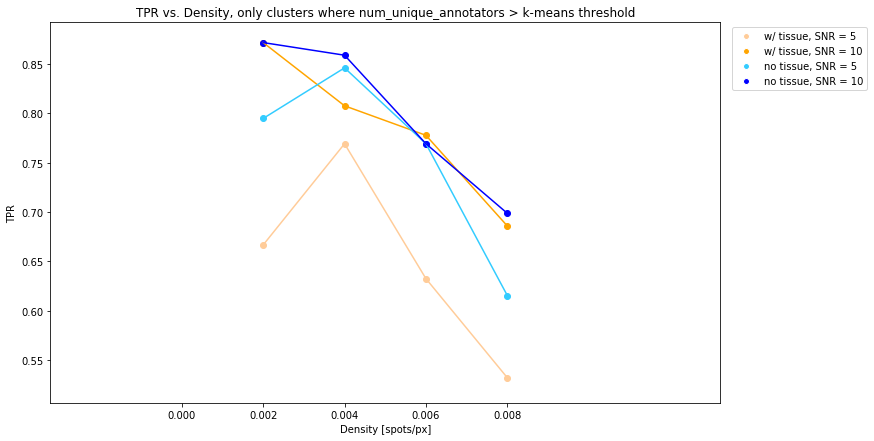

In [19]:
fig = plt.figure(figsize = (12,7))
plt.scatter(density_list, FPR_w_tissue_snr_5, c='#ffcc99')
plt.plot(density_list, FPR_w_tissue_snr_5, c='#ffcc99')
plt.scatter(density_list, FPR_w_tissue_snr_10, c='orange')
plt.plot(density_list, FPR_w_tissue_snr_10, c='orange')
plt.scatter(density_list, FPR_no_tissue_snr_5, c='#33ccff')
plt.plot(density_list, FPR_no_tissue_snr_5, c='#33ccff')
plt.scatter(density_list, FPR_no_tissue_snr_10, c='blue')
plt.plot(density_list, FPR_no_tissue_snr_10, c='blue')
plt.xticks(np.arange(0,0.01,step=0.002))
plt.title('FPR vs. Density, only clusters where num_unique_annotators > k-means threshold')
plt.xlabel('Density [spots/px]')
plt.ylabel('FPR')
plt.legend(handles = legend_elements, bbox_to_anchor=(1.01, 1), loc=2)
plt.show()

fig = plt.figure(figsize = (12,7))
plt.scatter(density_list, TPR_w_tissue_snr_5, c='#ffcc99')
plt.scatter(density_list, TPR_w_tissue_snr_10, c='orange')
plt.scatter(density_list, TPR_no_tissue_snr_5, c='#33ccff')
plt.scatter(density_list, TPR_no_tissue_snr_10, c='blue')
plt.plot(density_list, TPR_w_tissue_snr_5, c='#ffcc99')
plt.plot(density_list, TPR_w_tissue_snr_10, c='orange')
plt.plot(density_list, TPR_no_tissue_snr_5, c='#33ccff')
plt.plot(density_list, TPR_no_tissue_snr_10, c='blue')
plt.xticks(np.arange(0,0.01,step=0.002))
plt.title('TPR vs. Density, only clusters where num_unique_annotators > k-means threshold')
plt.xlabel('Density [spots/px]')
plt.ylabel('TPR')
plt.legend(handles = legend_elements, bbox_to_anchor=(1.01, 1), loc=2)
plt.show()

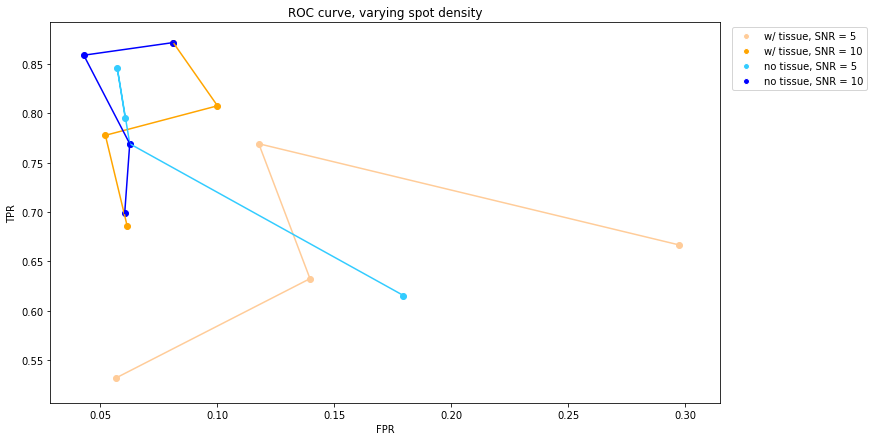

In [20]:
fig = plt.figure(figsize = (12,7))
plt.scatter(FPR_w_tissue_snr_5, TPR_w_tissue_snr_5, c='#ffcc99')
plt.scatter(FPR_w_tissue_snr_10, TPR_w_tissue_snr_10, c='orange')
plt.scatter(FPR_no_tissue_snr_5, TPR_no_tissue_snr_5, c='#33ccff')
plt.scatter(FPR_no_tissue_snr_10, TPR_no_tissue_snr_10, c='blue')
plt.plot(FPR_w_tissue_snr_5, TPR_w_tissue_snr_5, c='#ffcc99')
plt.plot(FPR_w_tissue_snr_10, TPR_w_tissue_snr_10, c='orange')
plt.plot(FPR_no_tissue_snr_5, TPR_no_tissue_snr_5, c='#33ccff')
plt.plot(FPR_no_tissue_snr_10, TPR_no_tissue_snr_10, c='blue')
plt.title('ROC curve, varying spot density')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(handles = legend_elements, bbox_to_anchor=(1.01, 1), loc=2)
plt.show()